# **Neutrino Oscillation with DUNE** (analysis version)

## PHYS591000 Physics AI Final Project

This is the project implementing ML to find out the $\Theta_{13}$ and $\delta_{cp}$ using the neutrino data from DUNE experiment.  
Original link: [Kaggle](https://www.kaggle.com/competitions/phys591000-2023-final-project-i)

> Author(s): Siang-Yuan Lin, Yuan-Yen Peng  
> Email(s) : sylin@gapp.nthu.edu.tw, garyphys0915@gapp.nthu.edu.tw  
> Licence : MIT  
> Data : May, 2023


### prerequisites

1. reset all varialbes
2. import curcial modules
3. mount google drive
4. check the GPU is on


In [1]:
# clear all variables
%reset -f

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import gc
import numpy as np
import scipy
import matplotlib.pyplot as plt

from numba import njit  # acceleration kernel
import tensorflow as tf


In [3]:
# check the tensorflow and GPU

print(f"Using Tensorflow {tf.__version__}")
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(
    f"Found GPU adn CPU.\nTensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}"
)


Using Tensorflow 2.9.0
Metal device set to: Found GPU adn CPU.
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



### import datasets

1. check files exist
2. retrieve data
3. check shapes of data


In [4]:
# import the datasets and check the files

path = "./phys591000-2023-final-project/"  # run on the local machine
# path = "/content/drive/Shareddrives/2023AI_final/2023AI_final/phys591000-2023-final-project/" # run on the google colab
# path = "/kaggle/input/phys591000-2023-final-project-i/"# Kaggle
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print("-> The file is", filename)
if not os.path.isfile(path + "neutrino_test_data.npz") or os.path.isfile(
    path + "neutrino_train_data.npz"
):
    raise FileNotFoundError("test/train data was not found or is a directory")


./phys591000-2023-final-project/neutrino_test_data.npz
-> The file is neutrino_test_data.npz
./phys591000-2023-final-project/neutrino_training_data.npz
-> The file is neutrino_training_data.npz


In [5]:
%%time
# take out data from the datasets

data_train = np.load(path + "neutrino_training_data.npz")  # ideal data
data_test = np.load(path + "neutrino_test_data.npz")  # pseudo-exp data

name_train = data_train.files
name_test = data_test.files

print(f"Train: {name_train}")
print(f"Test : {name_test}")

ve_train, vebar_train, vu_train, vubar_train, theta23_train, delta_train, ldm_train = map(lambda n: data_train[n], name_train)
ve_test, vebar_test, vu_test, vubar_test = map(lambda n: data_test[n], name_test)

Train: ['ve', 'vebar', 'vu', 'vubar', 'theta23', 'delta', 'ldm']
Test : ['ve', 'vebar', 'vu', 'vubar']
CPU times: user 10.6 s, sys: 553 ms, total: 11.2 s
Wall time: 11.5 s


In [6]:
# check the data shape

print(
    f"""# TRAIN
ve_train     :{ve_train.shape}
vebar_train  :{vebar_train.shape}
vu_train     :{vu_train.shape}
vubar_train  :{vubar_train.shape}
theta23_train:{theta23_train.shape}
delta_train  :{delta_train.shape}
ldm_train    :{ldm_train.shape}
"""
)
print(
    f"""# TEST
ve_test      :{ve_test.shape}
vebar_test   :{vebar_test.shape}
vu_test      :{vu_test.shape}
vubar_test   :{vubar_test.shape}
"""
)


# TRAIN
ve_train     :(1000000, 65)
vebar_train  :(1000000, 65)
vu_train     :(1000000, 65)
vubar_train  :(1000000, 65)
theta23_train:(1000000,)
delta_train  :(1000000,)
ldm_train    :(1000000,)

# TEST
ve_test      :(1000, 65)
vebar_test   :(1000, 65)
vu_test      :(1000, 65)
vubar_test   :(1000, 65)



### preprocessing

1. create train and test data
2. inspect data structure
3. check data
4. normalize data
5. <pending>


In [7]:
# create train and test data
X_train = np.stack((ve_train, vebar_train, vu_train, vubar_train), axis=-1)
Y_train = np.stack((theta23_train, delta_train, ldm_train), axis=-1)
X_test = np.stack((ve_test, vebar_test, vu_test, vubar_test), axis=-1)

print(
    f"""
The shape of x_train: {X_train.shape}
The shape of y_train: {Y_train.shape}
The shape of x_test : {X_test.shape}
"""
)



The shape of x_train: (1000000, 65, 4)
The shape of y_train: (1000000, 3)
The shape of x_test : (1000, 65, 4)



In [8]:
# define plotting functions


def four_plot(data_format: list) -> None:
    train, test = data_format
    bins = np.arange(0.625, 8 + 0.125, 0.125)
    name = [r"$\nu_e$", r"$\bar{\nu}_e$", r"$\nu_\mu$", r"$\bar{\nu}_\mu$"]

    fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=80, constrained_layout=True)
    fig.suptitle("First 60 features")
    for i, (train_data, test_data, name) in enumerate(zip(train, test, name)):
        ax = axes[i // 2, i % 2]
        ax.set_title(name)
        ax.step(bins, train_data[:60], label="train")
        ax.step(bins, test_data[:60], label="test")
        ax.legend(loc="best")
        ax.set_xlabel("Energy E [GeV]")
        ax.set_ylabel(r"Flux density $\phi\ [kg\cdot s^{-1}\cdot m^{-2}]$")

    plt.show()
    print("Success to plot")
    plt.close()
    return


def four_2d_plot(data_format: list) -> None:
    name = [r"$\nu_e$", r"$\bar{\nu}_e$", r"$\nu_\mu$", r"$\bar{\nu}_\mu$"]
    vmin = min(np.min(data_format[0]), np.min(data_format[1]))
    vmax = max(np.max(data_format[0]), np.max(data_format[1]))
    dataset_name = ["train", "test"]
    fig, axes = plt.subplots(2, 1, figsize=(10, 4), dpi=80, constrained_layout=True)
    fig.suptitle("First 60 features")
    for i, data in enumerate(data_format):
        ax = axes[i]
        im = ax.imshow(data.T, origin="lower")
        ax.set_title(dataset_name[i])
        ax.set_xlabel("Energy E [GeV]")
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(name)
        im.set_clim(vmin, vmax)
    cbar = fig.colorbar(im, ax=axes, location="bottom", aspect=25, pad=0.1)
    cbar.ax.set_title(r"Flux density $\phi\ [kg\cdot s^{-1}\cdot m^{-2}]$")
    plt.show()
    print("Success to plot")
    plt.close()
    return


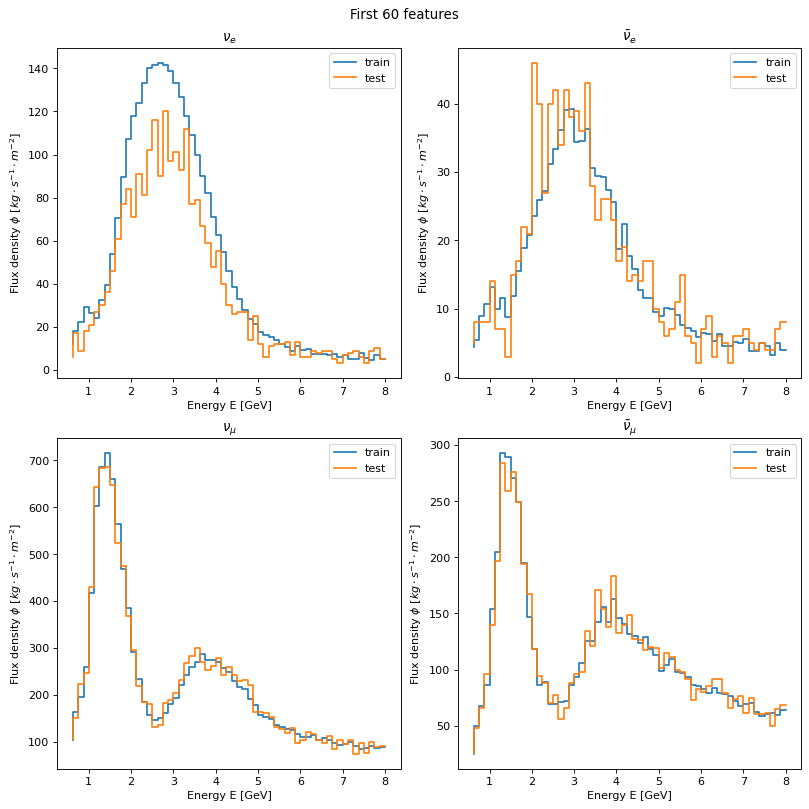

Success to plot


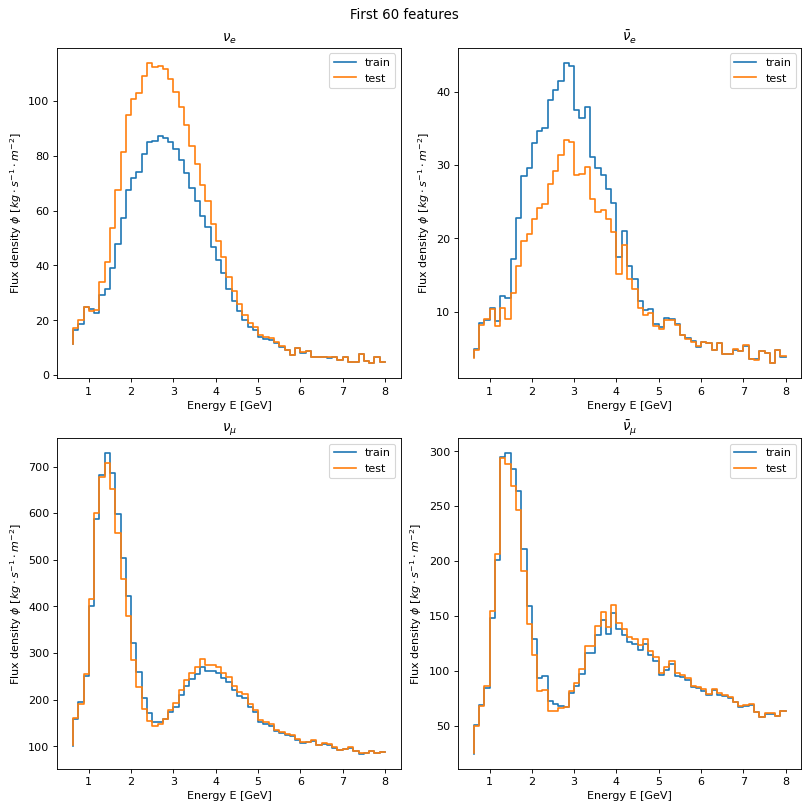

Success to plot


In [9]:
# inspect data structures

# check ``1D images''
train_10 = [ve_train[10], vebar_train[10], vu_train[10], vubar_train[10]]
test_10 = [ve_test[10], vebar_test[10], vu_test[10], vubar_test[10]]
train_average = [
    np.average(ve_train, axis=0),
    np.average(vebar_train, axis=0),
    np.average(vu_train, axis=0),
    np.average(vubar_train, axis=0),
]
test_average = [
    np.average(ve_test, axis=0),
    np.average(vebar_test, axis=0),
    np.average(vu_test, axis=0),
    np.average(vubar_test, axis=0),
]
data_format = [train_10, test_10]
data_sum_format = [train_average, test_average]
four_plot(data_format)
four_plot(data_sum_format)

# check ``2D images''
for i in [9, 99, 999]:
    data_format = [X_train[i, 0:60, :], X_test[i, 0:60, :]]
#     four_2d_plot(data_format)


The max of $\Theta_{13}$ [rad] is 51.1;
The min of $\Theta_{13}$ [rad] is 38.9;
The avg of $\Theta_{13}$ [rad] is 45.002699455700025.

The max of $\delta_{cp}$ [rad] is 360.0;
The min of $\delta_{cp}$ [rad] is 8.54954e-05;
The avg of $\delta_{cp}$ [rad] is 180.1832076771041.



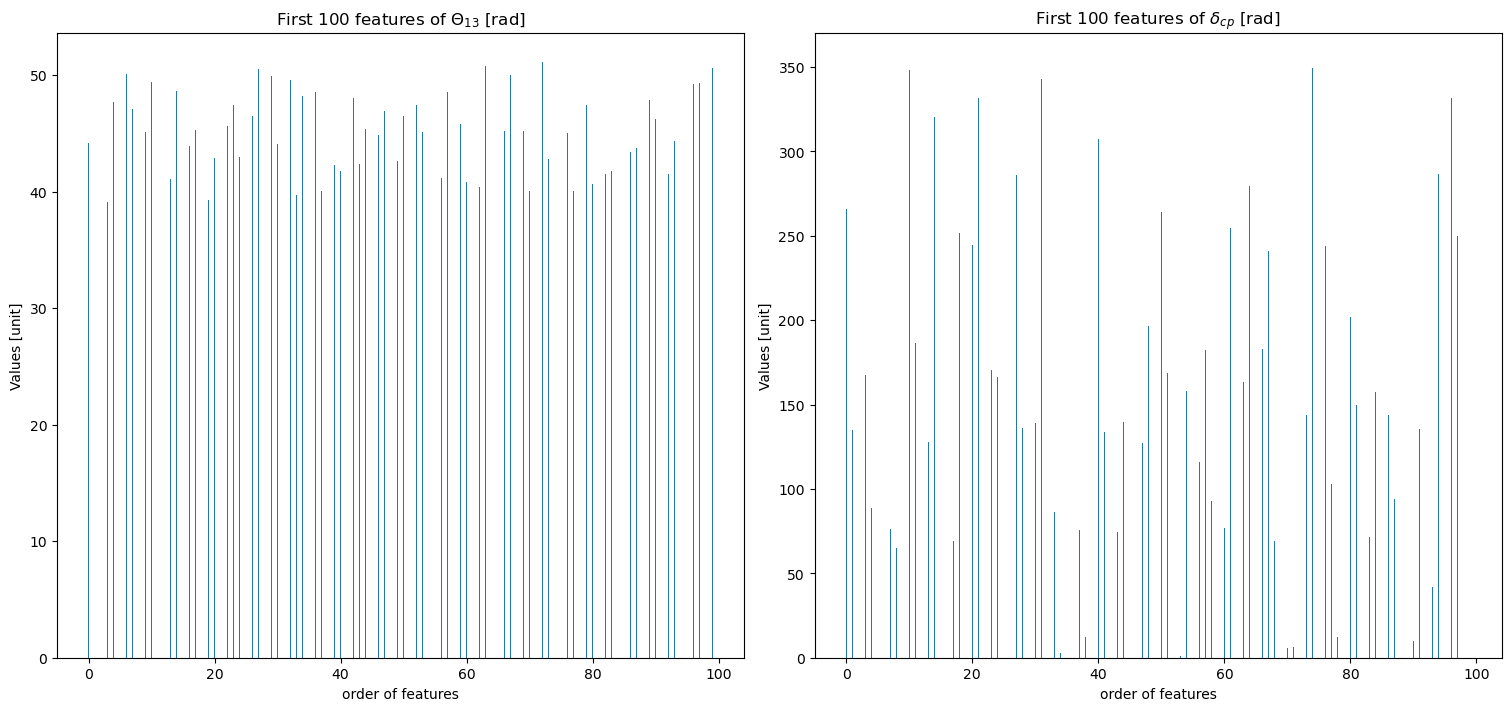

In [10]:
# check theta and delta relations

fig, axes = plt.subplots(1, 2, figsize=(15, 7), dpi=100, constrained_layout=True)
for i, name in enumerate([r"$\Theta_{13}$ [rad]", r"$\delta_{cp}$ [rad]"]):
    print(
        f"""The max of {name} is {np.max(Y_train[:, i])};
The min of {name} is {np.min(Y_train[:, i])};
The avg of {name} is {np.average(Y_train[:, i])}.
"""
    )
    ax = axes[i]
    n = 100
    ax.bar(np.arange(n), Y_train[:n, i], width=0.1)
    ax.set_title(f"First 100 features of {name}")
    ax.set_xlabel("order of features")
    ax.set_ylabel("Values [unit]")
plt.show()
plt.close()


In [11]:
train_normal = X_train[ldm_train > 0]
train_invert = X_train[ldm_train < 0]
theta23_normal = theta23_train[ldm_train > 0]
theta23_invert = theta23_train[ldm_train < 0]
delta_normal = delta_train[ldm_train > 0]
delta_invert = delta_train[ldm_train < 0]


def norm_alg(input_data):
    data_max = np.max(input_data, axis=0)
    offset = np.min(input_data, axis=0)
    scale = data_max - offset
    input_data = (input_data - offset) / scale
    return input_data


# normalize labels to [0,1]
ldm_train_norm = norm_alg(ldm_train)
theta23_NH_norm = norm_alg(theta23_normal)
theta23_IH_norm = norm_alg(theta23_invert)
delta_NH_norm = norm_alg(delta_normal)
delta_IH_norm = norm_alg(delta_invert)

# normalize training data to [0,1]
MAX_X = np.max(X_train)
MIN_X = np.min(X_train)
train_NH_norm = (train_normal - MIN_X) / (MAX_X - MIN_X)
train_IH_norm = (train_invert - MIN_X) / (MAX_X - MIN_X)
labeling = np.where(ldm_train > 0, 1, 0)

"""
[Train X] normalize training data to [0,1]
"""
x_train_NH = X_train[ldm_train > 0]
print(f"Before normalized, the shape of x_train: {x_train_NH.shape}")
MAX_X = np.max(x_train_NH)
MIN_X = np.min(x_train_NH)
print(f"X-train normalized factors (MAX_X, MIN_X) = ({MAX_X}, {MIN_X})")
x_train_NH_norm = (x_train_NH - MIN_X) / (MAX_X - MIN_X)
print(f"After normalized, the shape of x_train: {x_train_NH_norm.shape} \n")

"""
[Test X] normalize training data to [0,1]
"""
x_test_NH = X_test
print(f"Before normalized, the shape of x_test: {x_test_NH.shape}")
# share the same MinMax values of X_train
x_test_NH_norm = (x_test_NH - MIN_X) / (MAX_X - MIN_X)
print(f"After normalized, the shape of x_test: {x_test_NH_norm.shape} \n")

"""
[Train Y] normalize training label to [0,1]
"""
# choose Theta_23
y_train_NH = Y_train[:, 0][ldm_train > 0]
print(f"Before normalized, the shape of y_train: {y_train_NH.shape}")
MAX_Y = np.max(y_train_NH)
MIN_Y = np.min(y_train_NH)
y_train_NH_norm = (y_train_NH - MIN_Y) / (MAX_Y - MIN_Y)
print(
    f"Y-train normalized factors (MAX_Y, MIN_Y) = ({MAX_Y}, {MIN_Y})"
)
print(f"After normalized, the shape of y_train: {y_train_NH_norm.shape}")

Before normalized, the shape of x_train: (500027, 65, 4)
X-train normalized factors (MAX_X, MIN_X) = (1919.03, 2.74423)
After normalized, the shape of x_train: (500027, 65, 4) 

Before normalized, the shape of x_test: (1000, 65, 4)
After normalized, the shape of x_test: (1000, 65, 4) 

Before normalized, the shape of y_train: (500027,)
Y-train normalized factors (MAX_Y, MIN_Y) = (51.1, 38.9)
After normalized, the shape of y_train: (500027,)


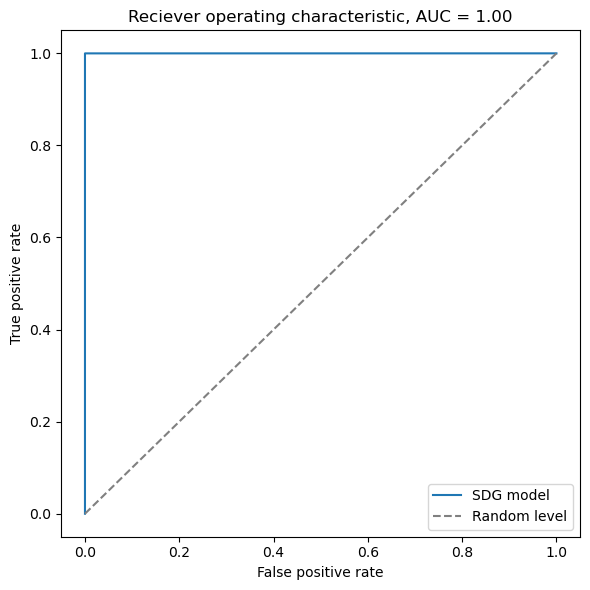

19565

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

ldm_class = SGDClassifier(max_iter=1000, tol=1e-3)
ldm_class.fit(X_train[:, :, 0], labeling)
train_predict = ldm_class.predict(X_train[:, :, 0])

fpr, tpr, thresholds = metrics.roc_curve(labeling, train_predict, pos_label=1)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label="SDG model")
plt.plot([0, 1], [0, 1], label="Random level", ls="dashed", c="Grey")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title(
    "Reciever operating characteristic, AUC = {:.2f}".format(metrics.auc(fpr, tpr))
)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# clear unused variables
del ldm_class
del (
    train_normal,
    train_invert,
    theta23_normal,
    theta23_invert,
    delta_normal,
    delta_invert,
)
del (
    ve_train,
    vebar_train,
    vu_train,
    vubar_train,
    theta23_train,
    delta_train,
    ldm_train,
    ve_test,
    vebar_test,
    vu_test,
    vubar_test,
)
gc.collect()

### model


In [13]:
# create validation data
from sklearn.model_selection import train_test_split

# split the training dataset into training and validation, with test_size = 0.2
tf.random.set_seed(2023)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_NH_norm, y_train_NH_norm, test_size=0.2, shuffle=True
)
x_test = X_test
print(
    f"""
The shape of x_train     : {x_train.shape}
The shape of y_train     : {y_train.shape}
The shape of x_validation: {x_val.shape}
The shape of y_validation: {y_val.shape}
The shape of x_test      : {x_test.shape}
"""
)

del X_train, Y_train, X_test, x_train_NH_norm, y_train_NH_norm



The shape of x_train     : (400021, 65, 4)
The shape of y_train     : (400021,)
The shape of x_validation: (100006, 65, 4)
The shape of y_validation: (100006,)
The shape of x_test      : (1000, 65, 4)



In [14]:
from sklearn.metrics import mean_squared_error


def analysis(x_train_pred, y_train) -> None:
    # set statistical parameters
    n = len(x_train_pred)
    dof = n - 2
    t = scipy.stats.t.ppf(0.975, dof)

    # linear fitting line
    slope, intercept = np.polyfit(x_train_pred, y_train, 1)
    slope, intercept, r, p, se = scipy.stats.linregress(x_train_pred, y_train)
    plt_min = np.min([np.min(x_train_pred), np.min(y_train)])
    plt_max = np.max([np.max(x_train_pred), np.max(y_train)])
    x_line = np.linspace(plt_min, plt_max, 100)
    y_line = np.polyval([slope, intercept], x_line)

    # acceleration kernel (to calculate mse, confident level, and prediction level)
    @njit(fastmath=True)
    def mse_kernel(pred, true, t_value=t, n=n, dof=dof, x_line=x_line, y_line=y_line):
        if true.shape != pred.shape:
            raise ValueError("True/Pred data should be the same shape!")
        mse = np.empty(len(true))
        for ind, (t, p) in enumerate(zip(true, pred)):
            mse[ind] = np.average(np.square(t - p))
        pred_mean = np.average(x_train_pred)
        sum_se = np.sum(np.square(true - pred))
        std_error = np.sqrt(1 / dof * sum_se)
        # confidence interval
        ci = (
            t_value
            * std_error
            * np.sqrt(
                1 / n
                + np.square(x_line - pred_mean)
                / np.sum(np.square(x_train_pred - pred_mean))
            )
        )
        # predicting interval
        pi = (
            t_value
            * std_error
            * np.sqrt(
                1
                + 1 / n
                + np.square(x_line - pred_mean)
                / np.sum(np.square(x_train_pred - pred_mean))
            )
        )
        return mse, ci, pi

    mse, ci, pi = mse_kernel(x_train_pred, y_train)

    fig = plt.figure(figsize=(7, 7), dpi=80)
    plt.scatter(x_train_pred, y_train, s=1, alpha=0.05, label="data")
    plt.plot(x_line, y_line, "--", lw=2, c="red", label="Fitting")
    plt.plot(
        [plt_min, plt_max], [plt_min, plt_max], "-", lw=1, c="orange", label="theo line"
    )
    plt.plot(
        x_line, y_line + pi, "--", lw=1, c="tab:red", label="95% prediction interval"
    )
    plt.plot(x_line, y_line - pi, "--", lw=1, c="tab:red")
    # plt.plot(x_line, y_line + ci, '--', c='tab:grey', label='95% confidence interval')
    # plt.plot(x_line, y_line - ci, '--', c='tab:grey')
    plt.xlim(plt_min, plt_max)
    plt.ylim(plt_min, plt_max)
    plt.legend(loc="best")
    plt.xlabel("Pred")
    plt.ylabel("True")
    plt.show()
    #
    mse_tot = mean_squared_error(x_train_pred, y_train)
    print(f"mean squared error = {mse_tot:.7e}")

    plt.title(r"$\Theta_{23}$")
    plt.xlabel("Train loss (MSE)")
    plt.hist(mse, bins=50, density=False, alpha=0.8, color="tab:blue")
    plt.show()

    return

In [15]:
# customized layer

from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class KLDivergenceLayer(Layer):

    """Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [16]:
def predict_norm_transpose(x_norm, y_norm):
    x = x_norm * (MAX_Y - MIN_Y) + MIN_Y
    y = y_norm * (MAX_Y - MIN_Y) + MIN_Y
    return x, y
def dataset_norm_transpose(x_norm, y_norm):
    x = x_norm * (MAX_X - MIN_X) + MIN_X
    y = y_norm * (MAX_Y - MIN_Y) + MIN_Y
    return x, y

In [17]:
from keras.utils import custom_object_scope

# load small_vgg (with norm data) and do the analysis
with custom_object_scope({"KLDivergenceLayer": KLDivergenceLayer}):
    normal_vgg = tf.keras.models.load_model(
        "./model/normal_mod_VGG.h5", compile=False
    )
    x_val_pred = normal_vgg.predict(x_val)
    # x_test_pred  = small_vgg.predict(x_test)
del normal_vgg

3126/3126 [==============================] - 37s 11ms/step


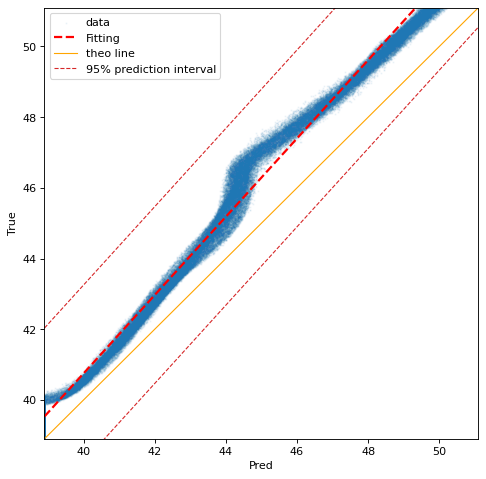

mean squared error = 1.6287611e+00


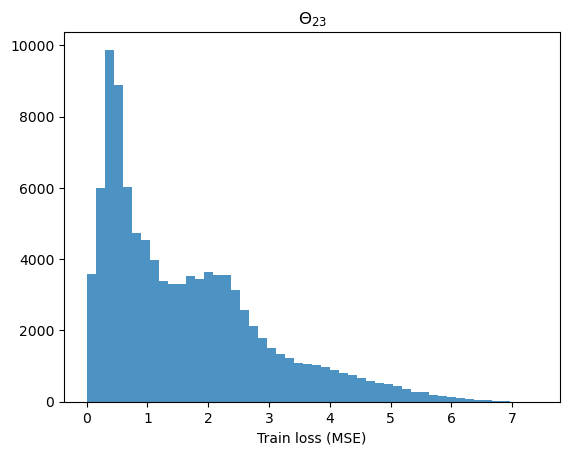

28079

In [18]:
x, y = predict_norm_transpose(x_val_pred[:, 0], y_val) 
analysis(x, y)
del x_val_pred, x, y
gc.collect()

In [19]:
# load small_vgg (with norm data) and do the analysis
with custom_object_scope({"KLDivergenceLayer": KLDivergenceLayer}):
    small_vgg = tf.keras.models.load_model(
        "./model/small_mod_VGG.h5", compile=False
    )
    x_val_pred = small_vgg.predict(x_val)
    # x_test_pred  = small_vgg.predict(x_test)
del small_vgg

3126/3126 [==============================] - 33s 10ms/step


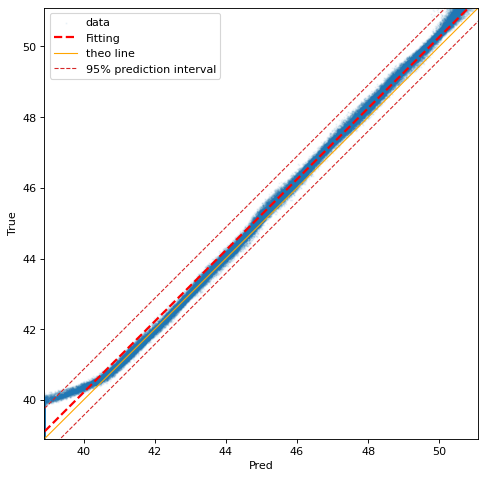

mean squared error = 1.1060209e-01


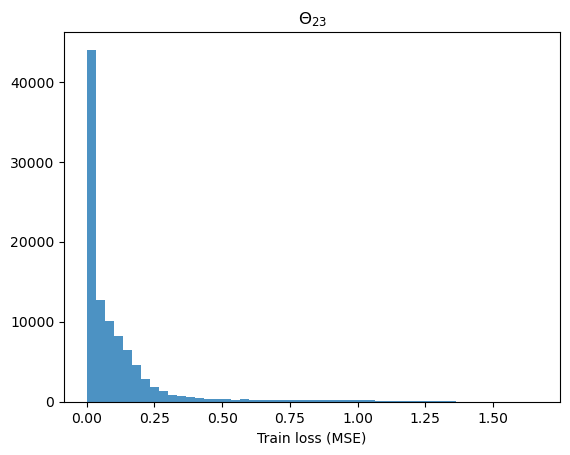

37664

In [20]:
x, y = predict_norm_transpose(x_val_pred[:, 0], y_val) 
analysis(x, y)
del x_val_pred, x, y
gc.collect()

In [21]:
# load large_vgg (with norm data) and do the analysis
with custom_object_scope({"KLDivergenceLayer": KLDivergenceLayer}):
    large_vgg = tf.keras.models.load_model(
        "./model/large_mod_VGG.h5", compile=False
    )
    x_val_pred = large_vgg.predict(x_val)
    # x_test_pred  = large_vgg.predict(x_test)
del large_vgg

3126/3126 [==============================] - 92s 29ms/step


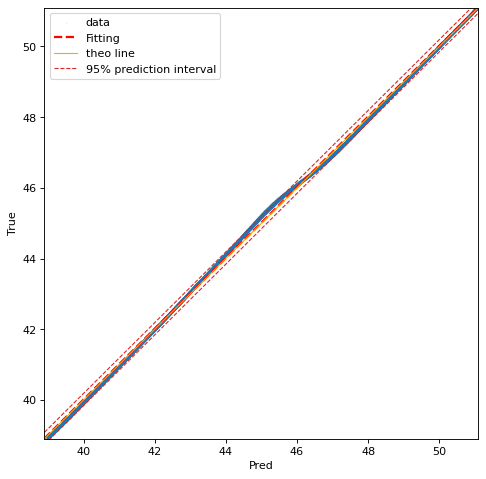

mean squared error = 7.7724271e-03


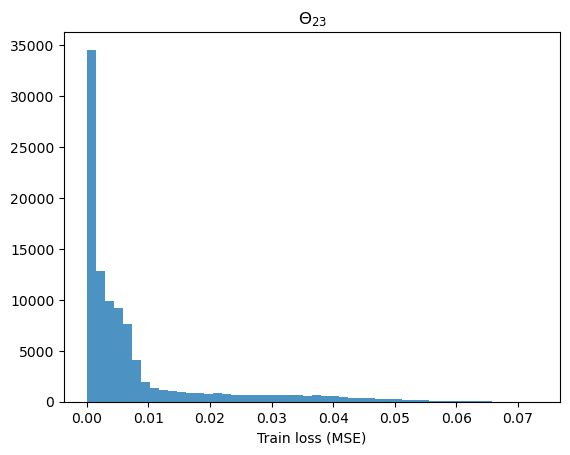

40612

In [22]:
x, y = predict_norm_transpose(x_val_pred[:, 0], y_val) 
analysis(x, y)
del x_val_pred, x, y
gc.collect()

In [23]:
# load large_vgg (with norm data) and do the analysis
with custom_object_scope({"KLDivergenceLayer": KLDivergenceLayer}):
    dcnn = tf.keras.models.load_model(
        "./model/DCNN.h5", compile=False
    )
    x_val_pred = dcnn.predict(x_val)
    # x_test_pred  = large_vgg.predict(x_test)
del dcnn

3126/3126 [==============================] - 31s 10ms/step


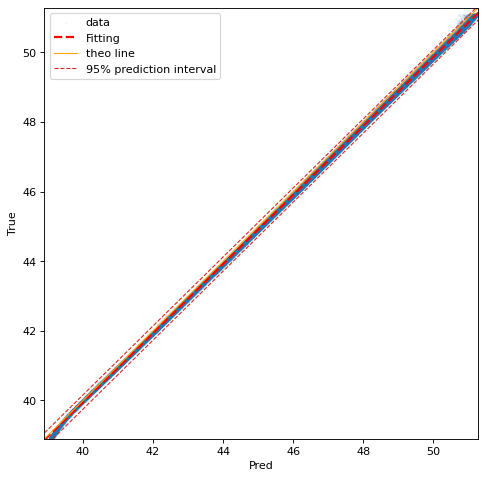

mean squared error = 1.0831460e-02


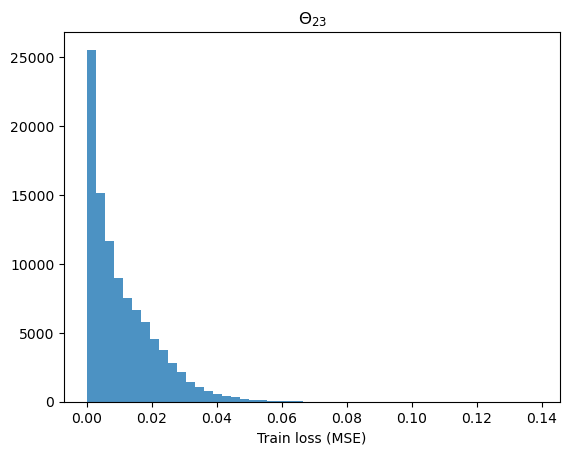

32636

In [24]:
x, y = predict_norm_transpose(x_val_pred[:, 0], y_val) 
analysis(x, y)
del x_val_pred, x, y
gc.collect()

In [25]:
# # load CVAE_norm (with norm data) and do the analysis
# with custom_object_scope({"KLDivergenceLayer": KLDivergenceLayer}):
#     cvae_norm = tf.keras.models.load_model(
#         "./model/CVAE_norm.h5", compile=False
#     )
#     x_val_pred = cvae_norm.predict(x_val)
#     # x_test_pred  = large_vgg.predict(x_test)
# del cvae_norm

3126/3126 [==============================] - 65s 20ms/step


/var/folders/6m/8m1_nvcx5dj45blhn0kz5x400000gn/T/ipykernel_76354/356510086.py:2: RankWarning: Polyfit may be poorly conditioned
  analysis(x, y)


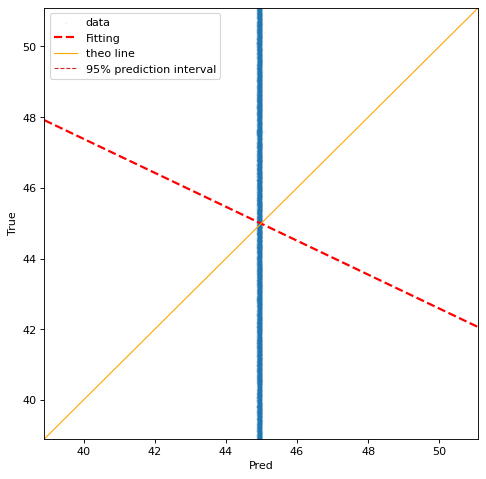

mean squared error = 1.2425961e+01


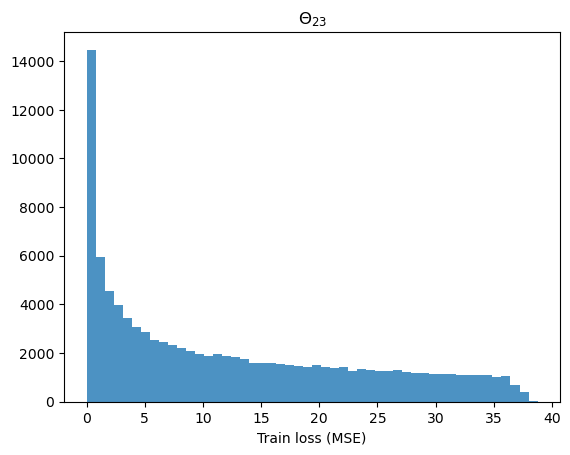

41468

In [26]:
# x, y = predict_norm_transpose(x_val_pred[:, 0], y_val) 
# analysis(x, y)
# del x_val_pred, x, y
# gc.collect()

In [28]:
# load CVAE (with ORRIGIN DATA) and do the analysis
x, y = dataset_norm_transpose(x_val, y_val) 
with custom_object_scope({"KLDivergenceLayer": KLDivergenceLayer}):
    cvae = tf.keras.models.load_model("./model/CVAE.h5", compile=False)
    x_val_pred = cvae.predict(x)
    # x_test_pred  = small_vgg.predict(x_unnorm)
del cvae

3126/3126 [==============================] - 31s 10ms/step


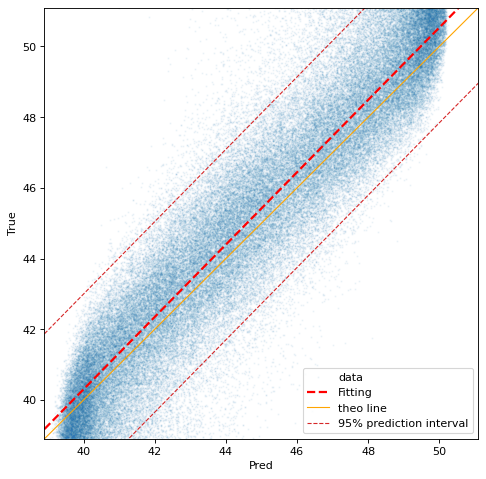

mean squared error = 1.8917827e+00


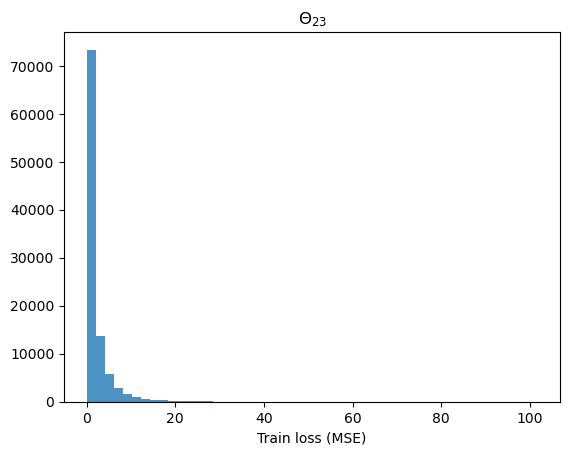

42336

In [29]:
analysis(x_val_pred[:, 0], y)
del x_val_pred, x, y
gc.collect()

In [27]:
# load DVAE_CNN (with ORIGINAL data) and do the analysis
x, y = dataset_norm_transpose(x_val, y_val) 
with custom_object_scope({"KLDivergenceLayer": KLDivergenceLayer}):
    dvae_cnn = tf.keras.models.load_model("./model/DVAE_CNN.h5", compile=False)
    x_val_pred = dvae_cnn.predict(x_val)
    # x_test_pred  = small_vgg.predict(x_test)
del dvae_cnn

 298/3126 [=>............................] - ETA: 55s

KeyboardInterrupt: 

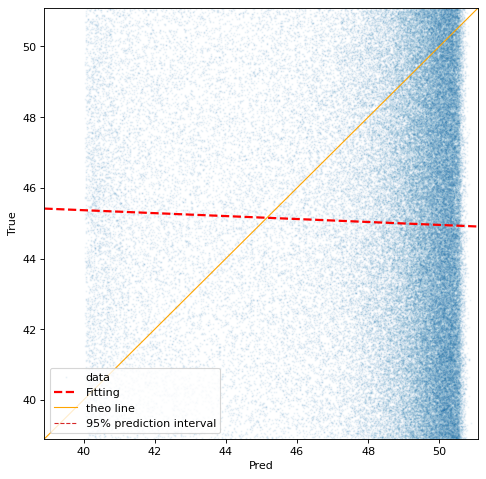

mean squared error = 3.1528222e+01


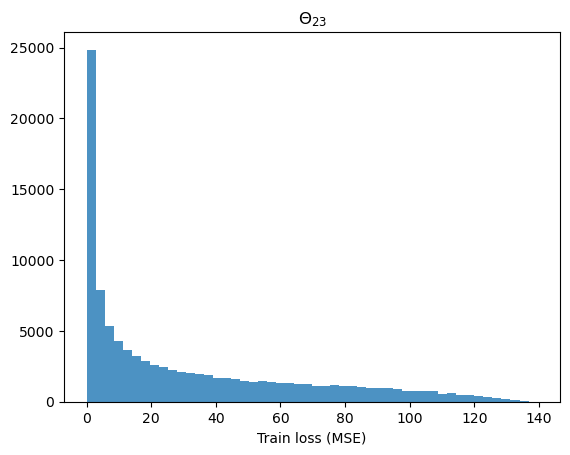

36729

In [62]:
analysis(x_val_pred[:, 0], y)
del x_val_pred, x, y
gc.collect()

In [63]:
# # load DVAE_DNN (with ORIGINAL data) and do the analysis
# x, y = dataset_norm_transpose(x_val, y_val) 
# with custom_object_scope({"KLDivergenceLayer": KLDivergenceLayer}):
#     dvae_dnn = tf.keras.models.load_model("./model/DVAE_CNN.h5", compile=False)
#     x_val_pred = dvae_dnn.predict(x_val)
#     # x_test_pred  = small_vgg.predict(x_test)
# del dvae_dnn

3126/3126 [==============================] - 65s 21ms/step


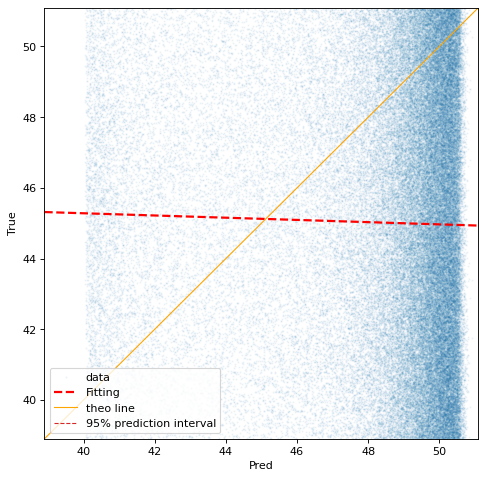

mean squared error = 3.1348372e+01


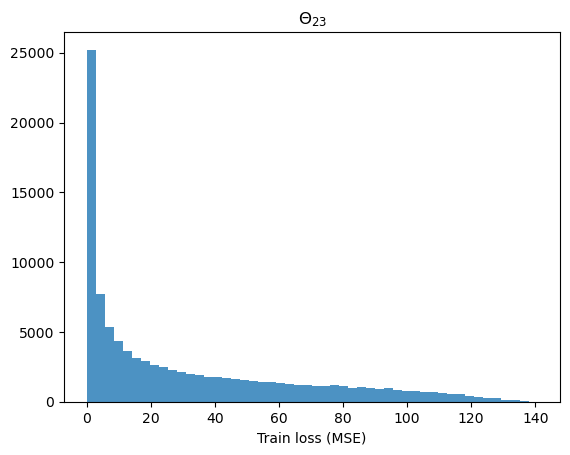

36729

In [64]:
# analysis(x_val_pred[:, 0], y)
# del x_val_pred, x, y
# gc.collect()

### dump the predicted data


In [ ]:
# # dump the predicted data
# """
# 0 for qcd; 1 for wprime
# """

# pred_label = [0 if i < cut else 1 for i in new_loss_data]
# np.savetxt("submission.csv", [('id', 'prediction')] + [(i, j) for i, j in enumerate(pred_label)], delimiter=",", fmt='%s')
